In [1]:
# pytorch version and gpu status check
import torch
print("PyTorch version: {}".format(torch.__version__))
print()
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print("device_count: {}".format(device_count))
    for device_num in range(device_count):
        print("device {} capa {}".format(
            device_num,
            torch.cuda.get_device_capability(device_num))
        )
        print("device {} name {}".format(
            device_num,
            torch.cuda.get_device_name(device_num))
        )
else:


PyTorch version: 1.9.0+cu102

device_count: 1
device 0 capa (6, 0)
device 0 name Tesla P100-PCIE-16GB


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

In [5]:
data = pd.read_csv('train.csv')
dataset = data.values
# split data into X and y
X = dataset[:,0:94]
y = dataset[:,94]
data.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,4,1,1,0,0,2,0,0,0,0,0,1,0,0,0,0,...,0,0,2,0,0,11,0,1,1,0,1,0,7,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,7,2,2,0,0,0,58,0,10,0,0,0,0,0,3,0,...,1,0,0,0,0,0,0,0,0,0,2,1,5,0,0,4,0,0,2,1,0,1,0,0,1,1,2,2,0,22,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,4,0,1,0,0,0,1,0,0,0,0,1,0,0,0,Class_1


In [6]:
subsample_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]

In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# grid search
model = XGBClassifier(tree_method="gpu_hist")
param_grid = dict(subsample=subsample_ratio)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
# grid search with all processors (n_jobs=-1)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=2)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: {:.6f} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("{:.6f} ({:.6f}) with: {}".format(mean, stdev, param))


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.9min finished


Best: -0.005793 using {'subsample': 0.7}
-0.007327 (0.001181) with: {'subsample': 0.1}
-0.006608 (0.001144) with: {'subsample': 0.2}
-0.006330 (0.001092) with: {'subsample': 0.3}
-0.006084 (0.001030) with: {'subsample': 0.4}
-0.006014 (0.000994) with: {'subsample': 0.5}
-0.005816 (0.000961) with: {'subsample': 0.6}
-0.005793 (0.000955) with: {'subsample': 0.7}
-0.005800 (0.000970) with: {'subsample': 0.8}
-0.005951 (0.000864) with: {'subsample': 1.0}


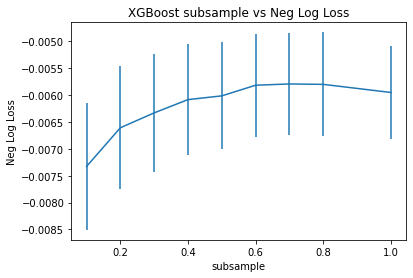

In [8]:
# plot
plt.errorbar(subsample_ratio, means, yerr=stds)
plt.title("XGBoost subsample vs Neg Log Loss")
plt.xlabel('subsample')
plt.ylabel('Neg Log Loss')
plt.show()

We can see that indeed 70% has the best mean performance.

### 2.2 - Tuning Column Subsampling in XGBoost By Tree
We can also create a random sample of the features (or columns) to use prior to creating each decision tree in the boosted model.

In the XGBoost wrapper for scikit-learn, this is controlled by the `colsample_bytree` parameter.

The default value is 1.0 meaning that all columns are used in each decision tree. We can evaluate values for `colsample_bytree` between 0.1 and 1.0 incrementing by 0.1.

In [9]:
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]

The full code listing is provided below.



In [10]:
# grid search
model = XGBClassifier(subsample=0.7, tree_method="gpu_hist")
param_grid = dict(colsample_bytree=colsample_bytree)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
# grid search with all processors (n_jobs=-1)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=2)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: {:.6f} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("{:.6f} ({:.6f}) with: {}".format(mean, stdev, param))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.0min finished


Best: -0.005793 using {'colsample_bytree': 1.0}
-0.328846 (0.002262) with: {'colsample_bytree': 0.1}
-0.117312 (0.000778) with: {'colsample_bytree': 0.2}
-0.045240 (0.000524) with: {'colsample_bytree': 0.3}
-0.019300 (0.000676) with: {'colsample_bytree': 0.4}
-0.010321 (0.000743) with: {'colsample_bytree': 0.5}
-0.007885 (0.000733) with: {'colsample_bytree': 0.6}
-0.006510 (0.000779) with: {'colsample_bytree': 0.7}
-0.005949 (0.000882) with: {'colsample_bytree': 0.8}
-0.005793 (0.000955) with: {'colsample_bytree': 1.0}


Plotting the results, we can see the performance of the model plateau (at least at this scale) with values between 0.5 to 1.0.

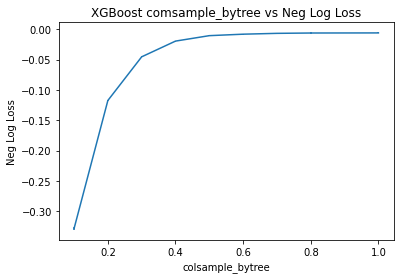

In [11]:
# plot
plt.errorbar(colsample_bytree, means, yerr=stds)
plt.title("XGBoost comsample_bytree vs Neg Log Loss")
plt.xlabel('colsample_bytree')
plt.ylabel('Neg Log Loss')
plt.show()

In [12]:
colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]

In [ ]:
# grid search
model = XGBClassifier(subsample=0.7, tree_method="gpu_hist")
param_grid = dict(colsample_bylevel=colsample_bylevel)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
# grid search with all processors (n_jobs=-1)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=2)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: {:.6f} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("{:.6f} ({:.6f}) with: {}".format(mean, stdev, param))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.0min finished


Best: -0.005793 using {'colsample_bylevel': 1.0}
-0.182268 (0.001191) with: {'colsample_bylevel': 0.1}
-0.049172 (0.000688) with: {'colsample_bylevel': 0.2}
-0.017162 (0.000582) with: {'colsample_bylevel': 0.3}
-0.008874 (0.000669) with: {'colsample_bylevel': 0.4}
-0.006467 (0.000696) with: {'colsample_bylevel': 0.5}
-0.005985 (0.000689) with: {'colsample_bylevel': 0.6}
-0.005866 (0.000774) with: {'colsample_bylevel': 0.7}
-0.005811 (0.000896) with: {'colsample_bylevel': 0.8}
-0.005793 (0.000955) with: {'colsample_bylevel': 1.0}


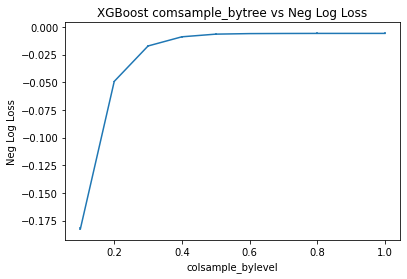

In [ ]:
# plot
plt.errorbar(colsample_bylevel, means, yerr=stds)
plt.title("XGBoost comsample_bytree vs Neg Log Loss")
plt.xlabel('colsample_bylevel')
plt.ylabel('Neg Log Loss')
plt.show()